# Action

[![Click and Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/metadriverse/metaurban/blob/main/documentation/source/action.ipynb)

This section will discuss how to control the vehicle in MetaUrban with the *Policy* interface. Before this, let's have a look at the raw control signal required by vehicles.

To control vehicles in MetaUrban, the input should be a normalized action: $\mathbf a = [a_1, a_2] \in [-1, 1]^2$. This action is converted into the steering $u_s$ (degree), acceleration $u_a$ (hp) and brake signal $u_b$ (hp) in the following ways:

$u_s = S_{max} a_1$  
$u_a = F_{max} \max(0, a_2)$  
$u_b = -B_{max} \min(0, a_2)$  

wherein $S_{max}$ (degree) is the maximal steering angle, $F_{max}$ (hp) is the maximal engine force, and $B_{max}$ (hp) is the maximal brake force. 
To increase diversity, the accurate values of these parameters vary across different vehicles but are limited to certain ranges defined by [ParameterSpace](https://github.com/metadriverse/metaurban/blob/main/metaurban/component/pg_space.py).

The steering $u_s$ is applied to two front wheels. In addition, the engine force $u_a$ and the brake force $u_b$ are applied to four wheels, as the COCO robot in MetaUrban is four-wheel drive (4WD). The concrete implementation is as follows:

In [2]:
from metaurban.component.delivery_robot.base_deliveryrobot import EgoDeliveryRobot
from metaurban.utils import print_source
print_source(EgoDeliveryRobot._set_action)
print_source(EgoDeliveryRobot._apply_throttle_brake)

def _set_action(self, action):
    if action is None:
        return
    steering = action[0]
    self.throttle_brake = action[1]
    self.steering = steering
    self.system.setSteeringValue(self.steering * self.max_steering, 0)
    self.system.setSteeringValue(self.steering * self.max_steering, 1)
    self._apply_throttle_brake(action[1])

def _apply_throttle_brake(self, throttle_brake):
    max_engine_force = self.config["max_engine_force"]
    max_brake_force = self.config["max_brake_force"]
    for wheel_index in range(4):
        if throttle_brake >= 0:
            self.system.setBrake(2.0, wheel_index)
            if self.speed_km_h > self.max_speed_km_h:
                self.system.applyEngineForce(0.0, wheel_index)
            else:
                self.system.applyEngineForce(max_engine_force * throttle_brake, wheel_index)
        else:
            if self.enable_reverse:
                self.system.applyEngineForce(max_engine_force * throttle_brake, wheel_index)
            

Actually, you can make the car 2WD or 4 wheel steering or even increase its number of wheels by implementing a new vehicle type like `EgoDeliveryRobot`.

The aforementioned `_set_action(self, action)` function is wrapped by the `before_step(self, action)` function, which will do additional manipulations like numerical validation. Thus to control the agent, just set the action through `agent.before_step(target_action)` before simulating the next step. A minimal example to control an agent is as follows. The script first creates a new agent in front of the green ego car and sets its action as `[0, 0.05]` at each step. As a result, it slowly moves forward, while the green ego car stops at the origin as its input action is always `[0, 0]`. 

In [8]:
from metaurban.envs import SidewalkStaticMetaUrbanEnv
from metaurban.component.delivery_robot.deliveryrobot_type import EgoVehicle
from metaurban.utils import generate_gif

env=SidewalkStaticMetaUrbanEnv(dict(map="S", traffic_density=0, object_density=0.1, walk_on_all_regions=False))
frames = []
try:
    env.reset()
    cfg=env.config["vehicle_config"]
    cfg["navigation"]=None # it doesn't need navigation system
    v = env.engine.spawn_object(EgoVehicle, 
                                vehicle_config=cfg, 
                                position=[30,0], 
                                heading=0)
    for _ in range(100):
        v.before_step([0, 0.5])
        env.step([0,0])
        env.agents['default_agent'].set_position([25, 0])
        frame=env.render(mode="topdown", 
                         window=False,
                         screen_size=(800, 200),
                         camera_position=(60, 7))
        frames.append(frame)
    generate_gif(frames, gif_name="demo.gif")
finally:
    env.close()

[INFO] Environment: SidewalkStaticMetaUrbanEnv
[INFO] MetaUrban version: 0.0.1
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.0.1
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1
[INFO] Agents are expected to walk on main sidewalks and crosswalks, not all regions
[INFO] Agents are expected to walk on main sidewalks and crosswalks, not all regions
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Agents are expected to walk on main sidewalks and crosswalks, not all regions
[INFO] Agents are expected to walk on main sidewalks and crosswalks, not all regions


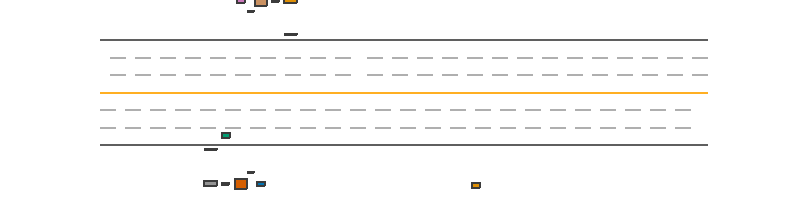

In [9]:
from IPython.display import Image
Image(open("demo.gif", "rb").read())